In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

import torch.nn.functional as F

import pandas as pd
from matplotlib import pyplot as plt

In [9]:
base_dir = '../Data_Generation/Data_files/labeled_points/'
base_fp = base_dir + '../points/sl2_Z_3s.csv'
test_fp = base_dir + 'sl2_Z_3s_test.csv'
train_fp = base_dir + 'sl2_Z_3s_train.csv'

### Network Architecture
$4\times1\to$ hidden layers $\to 4\times 1$

In [5]:
class DeepQModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(DeepQModel, self).__init__()
        self.stack = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, output_size),
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.stack(x)

In [6]:
MATRIX_SIZE = 4     # i.e. 2x2
NUM_GENERATORS = 4  # Number of generators in group (including inverses)

class DeepQAgent:
    def __init__(self, learning_rate: float, epsilon: float, epsilon_decay: float, 
                 min_epsilon: float, discount_factor: float, batch_size: int, memory_capacity: int):
        # Initialize main an target models and set weights to be equivalent
        self.mainModel = DeepQModel(MATRIX_SIZE, NUM_GENERATORS)
        self.targetModel = DeepQModel(MATRIX_SIZE, NUM_GENERATORS)
        
        # TODO: check if this works
        self.copy_main_to_target()

        # Initialize Hyperparameters
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.discount_factor = discount_factor
        self.batch_size = batch_size
        self.memory_capacity = memory_capacity

        # Optimization initialization
        self.optimizer = optim.Adam(self.mainModel.parameters(), lr=self.learning_rate)

        # Experience Replay Buffers and parameters
        self.memory = deque()
       
    def epsilon_greedy_search(self, state):
        if torch.rand(1) <= self.epsilon:
            return int(NUM_GENERATORS * torch.rand(1))
        x = torch.tensor(state)
        return self.mainModel.forward(x).argmax()

    def copy_main_to_target(self):
        self.targetModel.load_state_dict(self.mainModel.state_dict())

    def replay(self):
        # Ensure there is enough memory for a full batch
        if len(self.memory) <  self.batch_size:
            return

        # Random sample a batch_size's worth of memory
        minibatch = random.sample(self.memory, self.batch_size)

        # Vectorizing data
        states, actions, rewards, next_states, dones = zip(*minibatch)
        states = torch.tensor(states, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)
        
        # Bellman Equation: (Reward + discount_factor * state_prediction)
        target_predictions = self.targetModel.forward(next_states).max(dim=1)   # states
        bellmans = rewards + self.discount_factor * target_predictions
        next_q = self.mainModel.forward(states).max(dim=1)                      # next_states

        # Calculate loss and perform optimization step
        loss = F.mse_loss(next_q, bellmans)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Perform Epsilon decay for each training step
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
        
    def remember(self, state, action, reward, next_state, done: bool):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.memory_capacity:
            self.memory.popleft()



In [7]:
class DeepQAgenttester: 
    def __init__(self, agent: DeepQAgent, batch_size) -> None:
        self.batch_size = batch_size
        self.agent = agent
        pass

In [52]:
# Load data
df = pd.read_csv(base_fp)
train_df = pd.read_csv(train_fp)
test_df = pd.read_csv(test_fp)

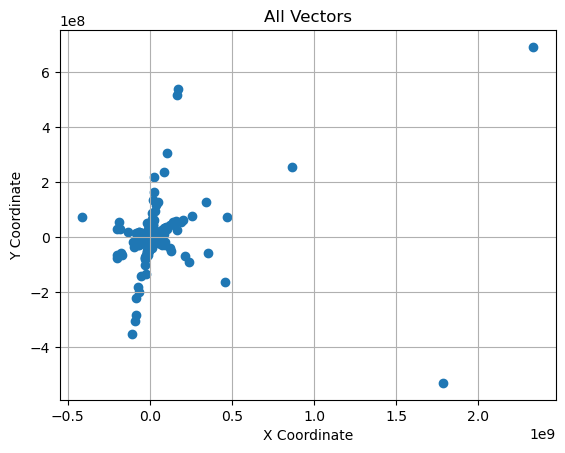

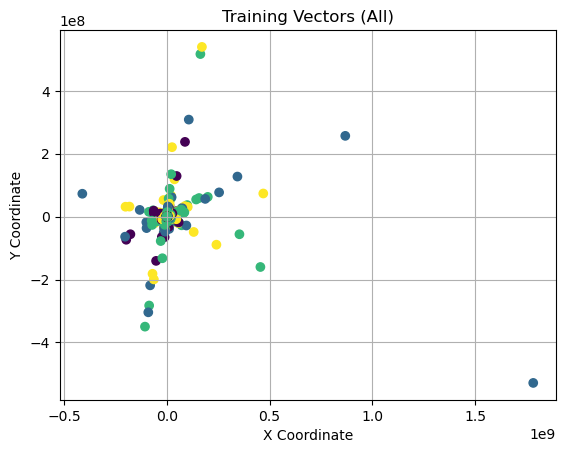

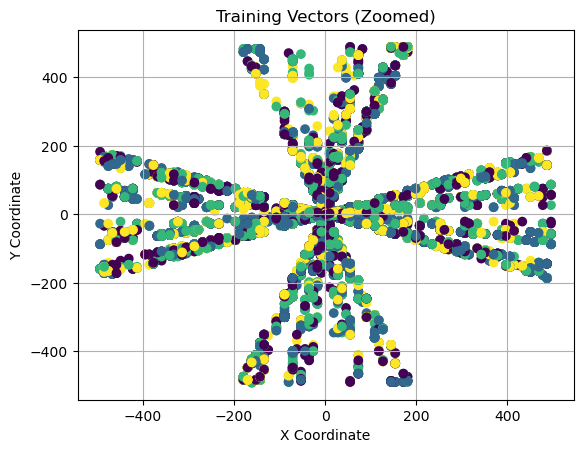

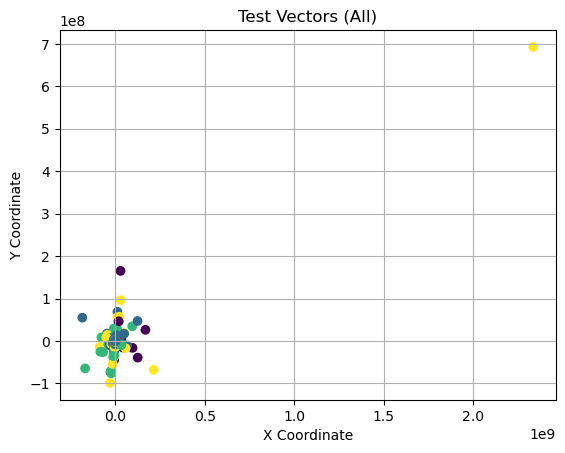

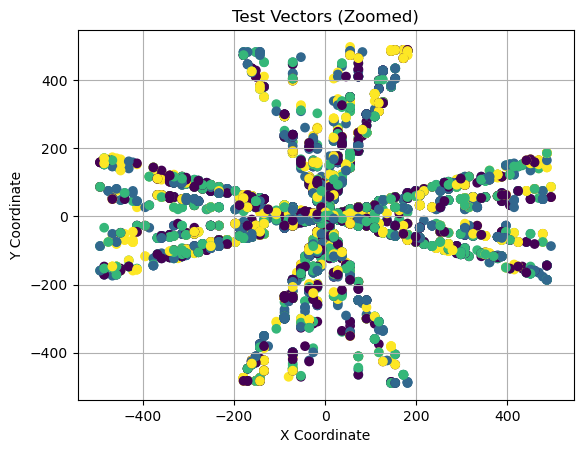

In [55]:
# All matrices
matrices_all = torch.tensor(df.values, dtype=torch.float64).reshape(100000, 2, 2)

# Training matrices and labels
train_data = torch.tensor(train_df.values, dtype=torch.float64)
labels_train = train_data[:,-1]
matrices_train = train_data[:,0:-2].reshape(train_data.shape[0], 2, 2)

# Testing matrices and labels
test_data = torch.tensor(test_df.values, dtype=torch.float64)
labels_test = test_data[:,-1]
matrices_test = test_data[:,0:-2].reshape(test_data.shape[0], 2, 2)

# Visualization vectors
basis_vec = torch.tensor([[1, 0]], dtype=torch.float64)
vecs_all = matrices_all.matmul(basis_vec.T)
vecs_train = matrices_train.matmul(basis_vec.T)
vecs_test = matrices_test.matmul(basis_vec.T)
x_train = vecs_train[:, 0]
x_test = vecs_test[:, 0]
y_train = vecs_train[:, 1]
y_test = vecs_test[:, 1]

# Training data masks to zoom plot
train_mask1 = x_train < 500
train_mask2 = x_train > -500
train_mask3 = y_train < 500
train_mask4 = y_train > -500
train_mask = train_mask1 & train_mask2 & train_mask3 & train_mask4

# Testing data mask to zoom plot
test_mask1 = x_test < 500
test_mask2 = x_test > -500
test_mask3 = y_test < 500
test_mask4 = y_test > -500
test_mask = test_mask1 & test_mask2 & test_mask3 & test_mask4

plt.scatter(vecs_all[:, 0], vecs_all[:, 1])
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('All Vectors')
plt.grid(True)
plt.show()

plt.scatter(x_train, y_train, c=labels_train)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Training Vectors (All)')
plt.grid(True)
plt.show()

plt.scatter(x_train[train_mask], y_train[train_mask], c=labels_train[train_mask.flatten()])
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Training Vectors (Zoomed)')
plt.grid(True)
plt.show()

plt.scatter(x_test, y_test, c=labels_test)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Test Vectors (All)')
plt.grid(True)
plt.show()

plt.scatter(x_test[test_mask], y_test[test_mask], c=labels_test[test_mask.flatten()])
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Test Vectors (Zoomed)')
plt.grid(True)
plt.show()